In [1]:
from droplet_growth import multiwell
import numpy as np
import pims_nd2 as nd
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter, binary_erosion, binary_fill_holes, label
from skimage.measure import regionprops, regionprops_table
%load_ext autoreload
%autoreload 2

In [23]:
from nd2shrink import transform
from tifffile import imread
import seaborn as sns
import pandas as pd
import os
from api import read
import logging
logging.basicConfig(level=logging.INFO)


In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys
sys.version

'3.8.1 (default, Jan  8 2020, 16:15:59) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [5]:
def show(bf, cmap='gray', **kwargs):
    plt.figure(figsize=(15,10))
    plt.imshow(bf, cmap=cmap, **kwargs)

In [6]:
prefix_win = "Z:/"
prefix_mac = '/Volumes/Multicell/'

In [7]:
prefix = os.path.join(prefix_mac, 'Andrey/data/Salome/20200228/scaled_stacks/')
prefix

'/Volumes/Multicell/Andrey/data/Salome/20200228/scaled_stacks/'

In [8]:
bf_path = prefix + 'C3_Z5_scale0.1.tif'
RFP_path = prefix + 'C1_Z5_scale0.1.tif'
GFP_path = prefix + 'C2_Z5_scale0.1.tif'
# control_path = '/Users/andrey/Documents/data-SGR/Time_lapse_control_E.coli_20x_downscale_16x.tif'

In [198]:
RFP_path = r'/Users/andrey/Documents/data-SGR/20200228/scaled_stacks/Images/Sum_Slices/C1/'

In [183]:
RFP_path = r'/Users/andrey/Documents/data-SGR/20200228/scaled_stacks/Images/Max Intensity Projection/C1/'

In [199]:
r = read.VirtualStack(RFP_path, regex=r'([ctmz])(\d{4})')

In [200]:
r

Virtial Stack instance. 
Found 33 files in /Users/andrey/Documents/data-SGR/20200228/scaled_stacks/Images/Sum_Slices/C1/. 
Ranges: {'t': {'min': 0, 'max': 32}}

In [15]:
bf_path

'/Volumes/Multicell/Andrey/data/Salome/20200228/scaled_stacks/C3_Z5_scale0.1.tif'

In [16]:
os.path.exists(bf_path)

True

In [17]:
bf_stack = imread(bf_path)
# RFP_stack = imread(RFP_path)
# GFP_stack = imread(GFP_path)


231  regions
4  bad regions
227 good regions


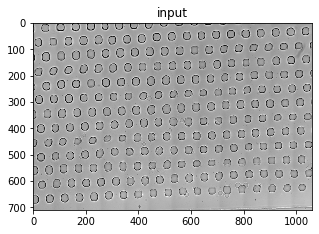

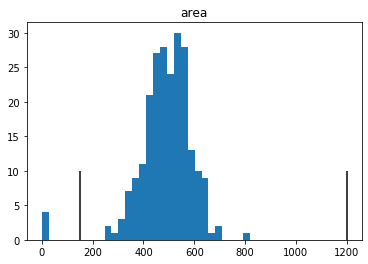

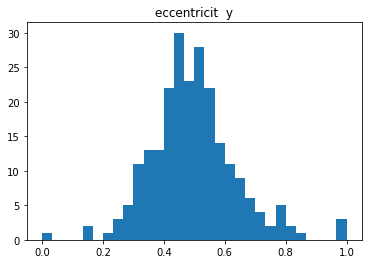

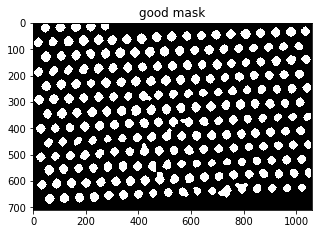

In [18]:
mask = multiwell.get_mask(bf_stack[0], thr=0.05, erode=15, post_dilate=5, area_lim=(150, 1200))

In [19]:
plt.imshow(mask)

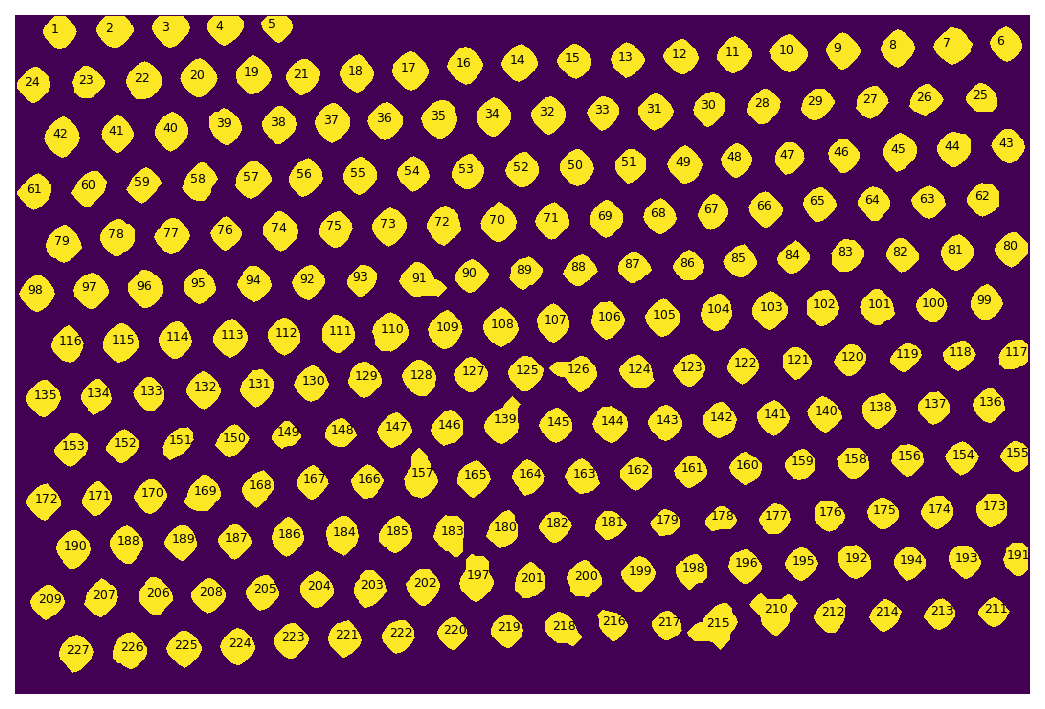

In [20]:
centers = multiwell.get_centers(mask, shift_labels=(-10,0), color='k')

In [96]:
logger = logging.getLogger('crop:crop')

def get_crop(well_image:read.Well, center:(int, int), size):
    img = well_image.array
#     logger.debug(f'get_crop: img.shape {img.shape}, center: {center}')
    x = max(0, int(center[1] - size / 2)), min(img.shape[1], int(center[1] + size / 2))
    y = max(0, int(center[0] - size / 2)), min(img.shape[1], int(center[0] + size / 2))
    crop = img[y[0]:y[1], x[0]:x[1]]
    return crop

def get_bg(crop, width=1):
    '''
    Cuts outer pixels of crop, returns mean intensity
    '''
    mask = np.ones_like(crop)
    mask = binary_erosion(mask, iterations=width)
    mask = np.logical_not(mask)
    value = crop[mask].mean()
    return min(value, crop.mean())

def get_table(reader, mask, size):
    centers = multiwell.get_centers(mask, plot=False)
    out = []
    for t, img in enumerate(reader):
        for c in centers:
            crop = get_crop(img, c['center'], size)
            bg = get_bg(crop)
            intensity = crop.mean()
            out.append({'t': t, 'w': c['label'], 'I': intensity, 'bg': bg})
    return pd.DataFrame(data=out)



In [201]:
table = get_table(r.read(), mask, 50)

In [188]:
table

t    w            I           bg
0      0    1  2184.613488  2184.613488
1      0    2  2074.560976  2074.560976
2      0    3  2086.723000  2086.723000
3      0    4  2251.616410  2192.706897
4      0    5  2112.800000  2112.800000
...   ..  ...          ...          ...
7486  32  223  3731.840400  2018.387755
7487  32  224  3545.070000  2011.801020
7488  32  225  1969.942400  1969.942400
7489  32  226  2097.811200  2073.005102
7490  32  227  3502.653600  2033.943878

[7491 rows x 4 columns]

In [202]:
table['II'] = table['I'] - table['bg']

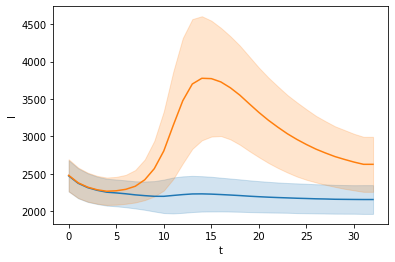

In [190]:
sns.lineplot(x='t', y='bg', data=table, ci='sd')

sns.lineplot(x='t', y='I', data=table, ci='sd')

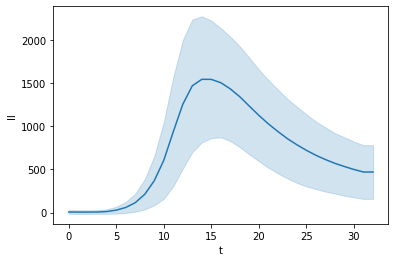

In [191]:
sns.lineplot(x='t', y='II', data=table, ci='sd')

In [192]:
sns.lineplot(x='t', y='II', data=table, ci=None, estimator=None, units="w")

In [203]:
sns.lineplot(x='t', y='II', data=table, ci=None, estimator=None, units="w")

In [42]:
table.II

0        -249.359375
1        -385.285156
2        -158.431641
3         471.158203
4        -265.382812
            ...     
7486    13225.375000
7487    12100.103516
7488     -434.546875
7489      197.218750
7490    10647.599609
Name: II, Length: 7491, dtype: float64

In [102]:
from droplet_growth import fit

In [180]:
def get_fits(table:pd.DataFrame, well_column='w', intensity_column='II'):
    '''
    Input: table with columns [well_column, intensity_column,time] must be sorted by time.
    Fits exponent to the intensity curve, 
    returns
    Pandas dataframe:
    ID index, 
    lag, - exponent multiplier
    lambda - doubling time
    Delay - time to reach 10% of max intensity
    '''
    fits = []
    wells = table[well_column].unique()
    for w in wells:
        t = table[table[well_column] == w]
        I = t[intensity_column].values
        I = I[0: np.argmax(np.gradient(I))]
        try:
            lag, lambd = fit.fit_exponent(I, plot=None)
    #         fit.exponent()
    #         I = b * np.exp(x / c)
    #         x = c * ln(I/b)
            delay = None
            if lag > 0 and I.max() > 0:
                delay = lambd * np.log(0.1 * I.max() / lag)
#                 delay = lambd * np.log(2500. / lag)
                
            if  lambd < 5:
                fits.append({'ID index': w, 'lag': lag, 'lambda': lambd, 'delay': delay})
            else:
                fits.append({'ID index': w, 'lag': None, 'lambda': None, 'delay': None})
        except (ValueError, RuntimeError, TypeError):
            fits.append({'ID index': w, 'lag': None, 'lambda': None, 'delay': None})
    return pd.DataFrame(data=fits)

In [193]:
df_fits = get_fits(table)

/Users/andrey/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [167]:
sns.swarmplot(x='ID index', y='lambda', data=df_fits)

Text(0.5, 1.0, 'Doubling time, frames')

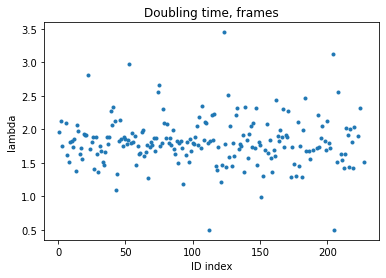

In [194]:
plt.plot('ID index', 'lambda', '.', data=df_fits,)
plt.xlabel('ID index')
plt.ylabel('lambda')
plt.title('Doubling time, frames')

In [195]:
plt.plot('ID index', 'lag', '.', data=df_fits,)
plt.xlabel('ID index')
plt.ylabel('lag')
plt.title('exponent prefactor')

Text(0.5, 1.0, 'exponent prefactor')

Text(0.5, 1.0, 'Time to reach certain intensity')

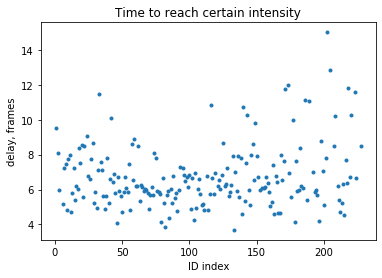

In [196]:
plt.plot('ID index', 'delay', '.', data=df_fits,)
plt.xlabel('ID index')
plt.ylabel('delay, frames')
plt.title('Time to reach certain intensity')

In [197]:
df_fits.to_csv('rates_feb_max_proj.csv', index=False)

In [108]:
rfp_table = multiwell.get_intensity_table(mask, RFP_stack)
plt.title('RFP')
# plt.ylim(300, 1700)

NameError: name 'RFP_stack' is not defined

In [14]:
gfp_table = multiwell.get_intensity_table(mask, GFP_stack)
plt.title('GFP')
# plt.ylim(300, 1700)

Text(0.5, 1.0, 'GFP')

In [111]:
gfp_table.to_csv(os.path.join(r'Z:\Andrey\data\Salome\20200228\Analysis', 'gfp_table.csv'))

In [112]:
rfp_table.to_csv(os.path.join(r'Z:\Andrey\data\Salome\20200228\Analysis', 'rfp_table.csv'))

In [15]:
p_gfp_table = gfp_table.pivot(index='label', columns='time', values='mean_intensity')
p_rfp_table = rfp_table.pivot(index='label', columns='time', values='mean_intensity')


In [16]:
filt = np.logical_and(p_rfp_table.values[:, 31] > 2500, p_rfp_table.values[:, 31] < 8000)

In [17]:
filt.shape

(204,)

In [18]:
fp_gfp_table = p_gfp_table.loc[filt]
fp_rfp_table = p_rfp_table.loc[filt]


In [24]:
_ = plt.semilogy(fp_gfp_table.T, 'b-', lw=0.5)
_ = plt.semilogy(fp_rfp_table.T, 'r-', lw=0.5)
plt.title('CIPRO Fluorescence red-RFP, blue-GFP')
plt.xlabel('time')

Text(0.5, 0, 'time')

In [105]:
def shape_curve(a):
    a_min, a_max = (a.argmin(),  np.gradient(a).argmax())
    aa = a #- a.min() + 1 
#     aa[:a_min] = 0
#     aa[a_max:] = 0
    return np.log(aa)[a_min+2:]

In [106]:
fp_gfp_table.values.shape

(186, 32)

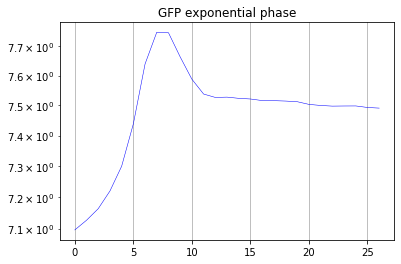

In [107]:
GFP_exp_phase = list(map(shape_curve, fp_gfp_table.values))
_ = plt.semilogy(GFP_exp_phase[20], 'b-', lw=0.5)
plt.title('GFP exponential phase')
plt.grid()

In [108]:
i = 0

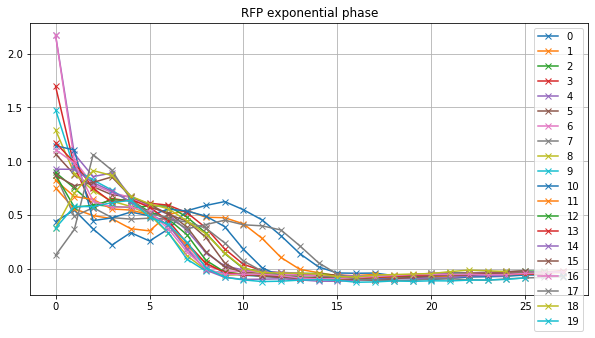

In [109]:
plt.figure(figsize=(10,5))
# RFP_exp_phase = np.apply_along_axis(shape_curve, 1, fp_rfp_table)
for i, curve in enumerate(RFP_exp_phase[:20]):
    _ = plt.plot(np.gradient(curve)[np.argmin(curve) + 2:], 'x-', lw=1.5, label=i)
# _ = plt.semilogy(GFP_exp_phase[:10].T, 'o-', lw=1.5)
plt.legend()
plt.title('RFP exponential phase')
plt.grid()
i+=1

ValueError: setting an array element with a sequence.

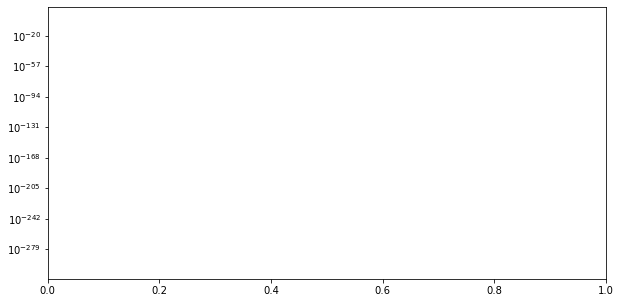

In [110]:
plt.figure(figsize=(10,5))
# RFP_exp_phase = np.apply_along_axis(shape_curve, 1, fp_rfp_table)
# _ = plt.semilogy(RFP_exp_phase[:10].T, 'x-', lw=1.5)
_ = plt.semilogy(GFP_exp_phase[10:20], 'o-', lw=1.5)
plt.legend()
plt.title('RFP exponential phase')
plt.grid()
i+=1

In [17]:

def correlate_exp_phases(gfp_table, rfp_table):
    corr = np.zeros_like(gfp_table)
    for i, (a, b) in enumerate(zip(gfp_table, rfp_table)):
#         corr[i] = np.correlate(shape_curve(a), shape_curve(b), 'same')
        corr[i] = np.correlate(a, b, 'same')
        
    return corr

In [18]:
corr = correlate_exp_phases(GFP_exp_phase, RFP_exp_phase)
corr.shape

NameError: name 'GFP_exp_phase' is not defined

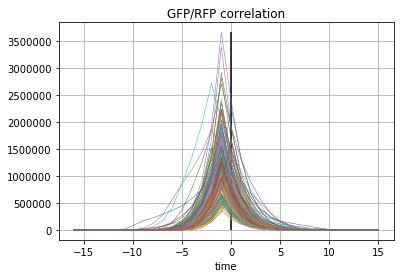

In [45]:
_ = plt.plot(range(-16,16), corr.T, lw=0.5)
plt.vlines(0, 0, np.max(corr))
plt.title('GFP/RFP correlation')
plt.xlabel('time')
plt.grid()

Text(0.5, 1.0, 'Correlation peak coord')

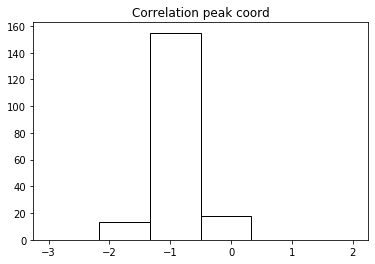

In [46]:
plt.hist(corr.argmax(axis=1) - 16, range=(-3,2), bins=6, fill=None)
plt.title('Correlation peak coord')
